# BERT for Sentiment analysis classification

In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Final_classification_code /Sentiment_analysis/sentiment_modify_pn.csv', engine='python')

In [4]:
dataset.shape

(250, 4)

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.6 MB/s eta 0:00:00


In [6]:
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, TFBertForSequenceClassification
from transformers import AutoTokenizer
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast

In [7]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [8]:
data_path = '/content/drive/MyDrive/Final_classification_code /Sentiment_analysis/sentiment_modify_pn.csv'

In [9]:
import numpy as np

from sklearn.model_selection import train_test_split

In [10]:
def get_train_ds(data_path, batch_size=8):
  data = pd.read_csv(data_path)
  data = data.sample(len(data)) # optionally sample a subset of the data
  print(f"Total Data: {len(data)}")
  X, y = list(data.NewsArticleText), list(data.label)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  train_encodings = tokenizer(X_train, truncation=True, padding=True)
  train_ds = tf.data.Dataset.from_tensor_slices((
      dict(train_encodings),
      y_train
  ))

  test_encodings = tokenizer(X_test, truncation=True, padding=True)
  test_ds = tf.data.Dataset.from_tensor_slices((
      dict(test_encodings),
      y_test
  ))

  train_ds = train_ds.batch(batch_size)
  test_ds = test_ds.batch(batch_size)

  return train_ds, test_ds

train_ds, test_ds = get_train_ds(data_path)

Total Data: 250


In [11]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.metrics.SparseCategoricalAccuracy()
              ) # can also use any keras loss fn

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
 model.fit(train_ds, epochs=5, verbose=1)

Epoch 1/5
24/24 [==============================] - 41s 927ms/step - loss: 0.4926 - sparse_categorical_accuracy: 0.7914
Epoch 2/5
24/24 [==============================] - 23s 960ms/step - loss: 0.2205 - sparse_categorical_accuracy: 0.9465
Epoch 3/5
24/24 [==============================] - 23s 973ms/step - loss: 0.0704 - sparse_categorical_accuracy: 0.9840
Epoch 4/5
24/24 [==============================] - 24s 993ms/step - loss: 0.0135 - sparse_categorical_accuracy: 1.0000
Epoch 5/5
24/24 [==============================] - 23s 971ms/step - loss: 0.0394 - sparse_categorical_accuracy: 0.9947


In [13]:
model.evaluate(test_ds)

8/8 [==============================] - 5s 327ms/step - loss: 0.1805 - sparse_categorical_accuracy: 0.9524


[0.18051597476005554, 0.9523809552192688]

In [14]:
predictions = model.predict(test_ds, verbose=1)

8/8 [==============================] - 5s 329ms/step


In [15]:
y_true = []
for x, y, in test_ds:
  for y_ in y:
    y_true.append(y_)

In [16]:
y_predict = np.argmax(predictions.logits, axis=1)

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
cm = confusion_matrix(y_true , y_predict)

In [19]:
import seaborn as sns

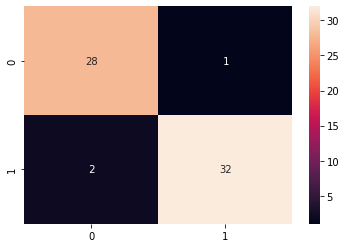

In [20]:
sns.heatmap(cm , annot=True ,fmt='2')

In [21]:
from sklearn.metrics import classification_report

# target_names = ['class 0', 'class 1']
target_names = ['Negative', 'Positive']

print(classification_report(y_true, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.93      0.97      0.95        29
    Positive       0.97      0.94      0.96        34

    accuracy                           0.95        63
   macro avg       0.95      0.95      0.95        63
weighted avg       0.95      0.95      0.95        63



In [22]:
out_model_path = "/content/drive/MyDrive/Final_classification_model_saved/Sentiment_analysis/"
tokenizer.save_pretrained(f"{out_model_path}")
model.save_pretrained(f"{out_model_path}")